In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import precision_recall_curve, roc_auc_score, precision_recall_fscore_support
from matplotlib import pyplot as plt
from sklearn.preprocessing import binarize

In [4]:
measure = pd.read_csv('../features2/measure_input.csv', index_col=0)
labels = np.array(measure.death)

In [5]:
measure = measure.drop(columns=["death"]).values
drug = pd.read_csv('../features2/drug_input.csv', index_col=0).drop(columns=["death"]).values
procedure = pd.read_csv('../features2/procedure_input.csv', index_col=0).drop(columns=["death"]).values
observe = pd.read_csv('../features2/observation_input.csv', index_col=0).drop(columns=["death"]).values
condition = pd.read_csv('../features2/condition_input.csv', index_col=0).drop(columns=["death"]).values

In [6]:
def fmax_score(labels, predictions, beta = 1.0, pos_label = 1):
    precision, recall, _ = precision_recall_curve(labels, predictions, pos_label)
    f1 = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    return np.nanmax(f1)

In [7]:
import pickle
def lr_individual(x_in_train, y_in_train,x_in_test, x_out_test,in_fold, out_fold, feature_name):
    lr = LR(class_weight={1:0.9,0:0.1})
    lr.fit(x_in_train,y_in_train)
    y_in_pred = lr.predict_proba(x_in_test)[:,1]
    y_out_pred = lr.predict_proba(x_out_test)[:,1]
    pickle.dump(lr,open("../models/inner_lr/lr_%s_%d_%d.pkl" %(feature_name, in_fold, out_fold), 'wb'))
    return y_in_pred, y_out_pred   

In [ ]:
kf = KFold(n_splits=10,random_state=2019,shuffle=False)

performances_dfs = []
i = 1
for outer_train_index, outer_test_index in kf.split(labels):    
    y_outer_train, y_outer_test = labels[outer_train_index], labels[outer_test_index]
    
    measure_outer_train, measure_outer_test = measure[outer_train_index], measure[outer_test_index]
    drug_outer_train, drug_outer_test = drug[outer_train_index], drug[outer_test_index]
    procedure_outer_train, procedure_outer_test = procedure[outer_train_index], procedure[outer_test_index]
    observe_outer_train, observe_outer_test = observe[outer_train_index], observe[outer_test_index]
    condition_outer_train, condition_outer_test = condition[outer_train_index], condition[outer_test_index]
    
    kf2 = KFold(n_splits=5,random_state=2019,shuffle=True)
    

    j = 1
    for in_train, in_test in kf2.split(measure_outer_train):
        
        y_in_train, y_in_test = y_outer_train[in_train], y_outer_train[in_test]
        
        measure_in_train, measure_in_test = measure_outer_train[in_train], measure_outer_train[in_test]
        
        drug_in_train, drug_in_test = drug_outer_train[in_train], drug_outer_train[in_test]
        
        procedure_in_train, procedure_in_test = procedure_outer_train[in_train], procedure_outer_train[in_test]
        
        observe_in_train, observe_in_test = observe_outer_train[in_train], observe_outer_train[in_test]
        
        condition_in_train, condition_in_test = condition_outer_train[in_train], condition_outer_train[in_test]
        
        measure_in_pred, measure_out_pred = lr_individual(measure_in_train, 
                                                          y_in_train, measure_in_test, measure_outer_test,i,j,"measure")
        
        drug_in_pred, drug_out_pred = lr_individual(drug_in_train,
                                                    y_in_train, drug_in_test, drug_outer_test,i,j,"drug")
        
        procedure_in_pred, procedure_out_pred = lr_individual(procedure_in_train,
                                                              y_in_train, procedure_in_test, procedure_outer_test,i,j,"procedure")
        
        observe_in_pred, observe_out_pred = lr_individual(observe_in_train, 
                                                          y_in_train, observe_in_test, observe_outer_test,i,j,"observation")
        
        condition_in_pred, condition_out_pred = lr_individual(condition_in_train,
                                                              y_in_train, condition_in_test, condition_outer_test,i,j,"condition")
             
        in_preds = pd.DataFrame({"measure": measure_in_pred, "drug": drug_in_pred,
                                "procedure":procedure_in_pred, "observation":observe_in_pred, 
                               "condition": condition_in_pred})
        
        out_preds = pd.DataFrame({"measure": measure_out_pred, "drug": drug_out_pred,
                                "procedure":procedure_out_pred, "observation":observe_out_pred, 
                               "condition": condition_out_pred})
        
        in_preds = in_preds[["measure","drug","procedure","observation","condition"]]
        out_preds = out_preds[["measure","drug","procedure","observation","condition"]]
        
        ensemble_lr = LR(class_weight={1:0.9,0:0.1})
        ensemble_lr.fit(in_preds.values, y_in_test)
        
        pickle.dump(ensemble_lr,open("../models/outer_lr/lr_%d_%d.pkl" %(i,j), 'wb'))
        
        ensemble_out_pred = ensemble_lr.predict_proba(out_preds)[:,1]
        precision, recall, thresholds = precision_recall_curve(y_outer_test, ensemble_out_pred)
        auc = roc_auc_score(y_outer_test, ensemble_out_pred)
        fmax = fmax_score(y_outer_test, ensemble_out_pred)
        performance_df = pd.DataFrame({"score":[auc, fmax], "eval_method":["AUC","F-Max"], "out_fold":[i,i], "in_fold":[j,j]}, index=[0,1])
        performances_dfs.append(performance_df)
        pred_df = pd.DataFrame({"prediction":ensemble_out_pred , "label": y_outer_test})
        
        pred_df.to_csv("preds_%d_%d.csv" %(i,j))
        j += 1
    i += 1
     

/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: De

/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: 

/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: De

/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: 

/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: De

In [14]:
performance = pd.concat(performances_dfs)

In [15]:
performance.to_csv("../results/ensemble_performance_180.csv")

In [2]:
performance = pd.read_csv("../results/ensemble_performance_180.csv")

In [10]:
df = pd.read_csv("preds_9_3.csv")
df

,Unnamed: 0,label,prediction
0,0,0,0.263099
1,1,0,0.462215
2,2,0,0.267967
3,3,0,0.460381
4,4,0,0.643548
5,5,0,0.289863
6,6,0,0.667927
7,7,0,0.577783
8,8,0,0.645667
9,9,0,0.316913


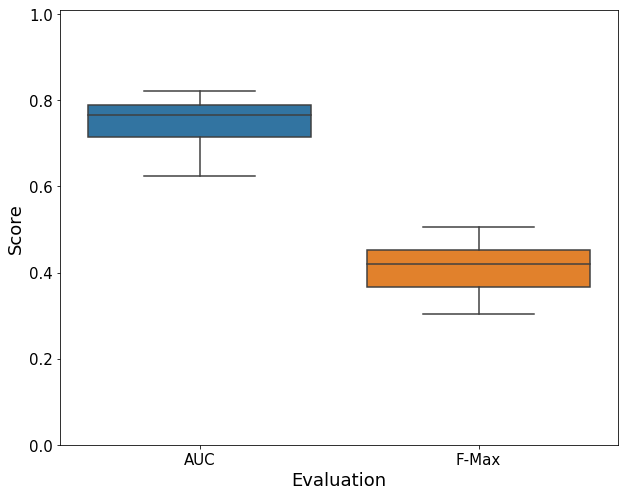

In [8]:

f = plt.figure(figsize=(10,8))
import seaborn as sns
sns.boxplot(data=performance,x="eval_method", y="score")

plt.xlabel("Evaluation", fontsize=18)
plt.ylabel("Score", fontsize=18)

plt.ylim(0,1.01)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.savefig("ensemble_performance_180.png", bbox_inches="tight")
plt.show()
plt.close()

In [17]:
performance.loc[performance.eval_method == "AUC",:].sort_values("score", ascending=False)

,eval_method,in_fold,out_fold,score
0,AUC,2,9,0.822270
0,AUC,3,9,0.820274
0,AUC,3,4,0.813803
0,AUC,5,9,0.810464
0,AUC,1,1,0.809128
0,AUC,1,9,0.808001
0,AUC,4,9,0.806047
0,AUC,1,4,0.804056
0,AUC,2,4,0.803756
0,AUC,5,4,0.803456


Text(0.5, 1.0, '2-class Precision-Recall curve')

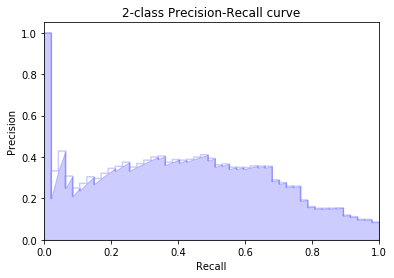

In [12]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, _ = precision_recall_curve(df.label,df.prediction)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')